## Resource-Constrained Project Scheduling

This notebook demonstrates how to model and solve the classical Resource-Constrained Project Scheduling Problem 
using Constraint Programming with IBM’s CP Optimizer via the [`docplex.cp`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API.

### Problem Definition

In the RCPSP, we are given a finite set of tasks indexed by $i \in \{1,\dots,N\}$ and a finite set of renewable resources indexed by $k \in \{1,\dots,M\}$. Each task $i$ has a fixed duration $PT_i>0$ and consumes $Q_{ik}\ge 0$ units of resource $k$ while it runs. Each resource $k$ has a capacity $C_k>0$. A set of precedence relations $P \subseteq \{1,\dots,N\}^2$ specifies required ordering (i.e., $(i,j)\in P$ means task $i$ must precede task $j$). The objective is to minimize the makespan $C_{\max}$ — the completion time of the last finishing task — while satisfying both precedence and resource limits.

### CPLEX Formulation

$$
\begin{aligned}
\min \quad & \max_{i \in [1..N]} \mathrm{endOf}(x_i) \qquad &\qquad & \text{(1)} \\
\text{s.t.} \quad
& \sum_{i \in [1..N]} \mathrm{pulse}(x_i, Q_{ik}) \le C_k, \qquad & \forall k \in [1..M] \quad & \text{(2)} \\
& \mathrm{endBeforeStart}(x_i, x_j), \qquad & \forall (i,j) \in P \quad & \text{(3)} \\
& \text{interval } x_i,\ \text{size} = PT_i, \qquad & \forall i \in [1..N] \quad & \text{(4)}
\end{aligned}
$$


**Objective:**
- **(1)** The **makespan** $C_{\max}$ — the completion time of the last finishing task — is **minimized**.

**Modeling constraints**:
- **(2)** At any time, resource usage on each renewable resource does not exceed its capacity.
- **(3)** All precedence relations are respected.

**Variables**:
- **(4)** We decide **start times** for all tasks via interval variables $x_i$ (one per task, fixed size $PT_i$).

#### Note on the [`pulse()`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.pulse) function

For a given task interval $x_i = [\,\mathrm{start}(x_i),\, \mathrm{end}(x_i)\,)$, the resource-usage profile on resource $k$ is defined by the step function $\mathrm{pulse}(x_i, Q_{ik})$:

$$
\mathrm{pulse}(x_i, Q_{ik})(t) =
\begin{cases}
Q_{ik}, & \text{if } t \in [\,\mathrm{start}(x_i),\, \mathrm{end}(x_i)\,) \\
0,      & \text{otherwise.}
\end{cases}
$$

So, during the time that task $i$ is active, this function takes the constant value $Q_{ik}$; otherwise, it is zero. Modeling this behavior without $\mathrm{pulse}()$ would require explicitly tracking every time instant, which is computationally expensive. $\mathrm{pulse}()$ instead provides a continuous-time abstraction that automatically handles overlapping tasks and resource capacities efficiently.


#### Symbols and Notation

| Symbol / Function | Meaning | docplex.cp reference |
|---|---|---|
| $N$ | Number of tasks | — |
| $M$ | Number of renewable resources | — |
| $i$ | Task index ($i \in [1..N]$) | — |
| $k$ | Resource index ($k \in [1..M]$) | — |
| $PT_i$ | Processing time (duration) of task $i$ | — |
| $Q_{ik}$ | Units of resource $k$ required by task $i$ (while $i$ runs) | — |
| $C_k$ | Available capacity of resource $k$ | — |
| $x_i$ | Interval variable for task $i$ | — |
| $\mathrm{endOf}(x_i)$ | End time of task $i$ | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) |
| $\mathrm{pulse}(x_i, Q_{ik})$ | Time-varying usage of resource $k$ by $i$ while $x_i$ executes | [docplex.cp.modeler.pulse](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.pulse) |
| $\mathrm{endBeforeStart}(x_i, x_j)$ | Enforce $j$ to start after $i$ ends | [docplex.cp.modeler.end_before_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) |
| $\text{interval } x_i, \text{ size} = PT_i$ | Declare $x_i$ with fixed duration | [docplex.cp.expression.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html#docplex.cp.expression.interval_var) |
| $\max_{i} \mathrm{endOf}(x_i)$ | Makespan of the project | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) |
| $\min C_{\max}$ | Objective: minimize makespan | [docplex.cp.modeler.minimize](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.minimize) |


### CPLEX Implementation

> This notebook is an adaptation of the *RCPSP* example from the [IBM Decision Optimization CPLEX Modeling for Python (DOcplex) Examples Repository](https://github.com/IBMDecisionOptimization/docplex-examples/tree/master).  

#### Imports

In [1]:
from docplex.cp.model import *

# Needed only for visualisation
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt

#### Reading the data file

In [2]:
filename = "../data/rcpsp/rcpsp_default.data"

# Available files are rcpsp_default, and different rcpsp_XXXXXX.
# First line contains the number of tasks, and the number of resources.
# Second line contains the capacities of the resources.
# The rest of the file consists of one line per task, organized as follows:
# - duration of the task
# - the demand on each resource (one integer per resource)
# - the number of successors followed by the list of successor numbers

with open(filename, "r") as f:
    N, M = [int(v) for v in f.readline().split()]  # N tasks, M resources
    C = [int(v) for v in f.readline().split()] # capacities C_k, k=1..M
    raw_tasks = [[int(v) for v in f.readline().split()] for _ in range(N)]

# Durations of the tasks PT_i
PT = [raw_tasks[i][0] for i in range(N)]

# Demands on the resource Q_{ik}
Q = [raw_tasks[i][1:M+1] for i in range(N)]

# Successor lists (1-based in file) -> precedence arcs P = {(i, j)}
succ_lists = [raw_tasks[i][M+2:] for i in range(N)]
P = [(i, j - 1) for i in range(N) for j in succ_lists[i]]


In [3]:
print(f"Number of tasks (N): {N}")
print(f"Number of resources (M): {M}")
print(f"Resource capacities: {C}\n")

for i in range(N):
    print(f"Task {i}: duration={PT[i]}, demand={Q[i]}, successors={succ_lists[i]}")

print(f"\nPrecedence arcs P = {P}")

Number of tasks (N): 35
Number of resources (M): 4
Resource capacities: [5, 5, 5, 5]

Task 0: duration=0, demand=[0, 0, 0, 0], successors=[2, 3, 4]
Task 1: duration=5, demand=[1, 0, 0, 0], successors=[5, 6, 7]
Task 2: duration=9, demand=[1, 0, 0, 0], successors=[11, 12]
Task 3: duration=3, demand=[1, 2, 0, 0], successors=[8, 9, 10]
Task 4: duration=5, demand=[0, 4, 2, 0], successors=[11]
Task 5: duration=6, demand=[2, 1, 2, 0], successors=[11]
Task 6: duration=1, demand=[3, 2, 2, 0], successors=[16]
Task 7: duration=4, demand=[0, 0, 0, 3], successors=[13]
Task 8: duration=8, demand=[0, 1, 1, 0], successors=[13]
Task 9: duration=1, demand=[3, 2, 0, 0], successors=[13]
Task 10: duration=4, demand=[1, 2, 0, 0], successors=[14, 15, 16, 17]
Task 11: duration=2, demand=[0, 4, 2, 4], successors=[14, 15, 16, 17]
Task 12: duration=2, demand=[0, 1, 1, 0], successors=[19]
Task 13: duration=5, demand=[3, 3, 0, 0], successors=[18]
Task 14: duration=6, demand=[0, 2, 0, 1], successors=[18]
Task 15: d

#### Create model and variables

In [4]:
# Create a CP Optimizer model
mdl = CpoModel()

# (4) Define interval variables for each task x_i with duration PT_i
x = [interval_var(name=f"T{i}", size=PT[i]) for i in range(N)]

#### Add constraints and define objective

In [ ]:
# (1) Objective: minimize max endOf(x_i)
mdl.add(minimize(mdl.max(end_of(x[i]) for i in range(N))))

# (2) Renewable resource capacities: sum_i pulse(x_i, Q_{ik}) <= C_k for each k
# pulse(xi,0) is identically zero. Including it changes nothing but creates extra expressions 
# for the solver to build and maintain. We avoid doing this by Q[i][k] > 0
mdl.add([sum(pulse(x[i], Q[i][k]) for i in range(N) if Q[i][k] > 0) <= C[k] for k in range(M)])

# (3) Precedences: endBeforeStart(x_i, x_j) for all (i, j) in P
mdl.add(end_before_start(x[i], x[j]) for (i, j) in P)

#### Solve the model

In [6]:
print('Solving model...')
res = mdl.solve(FailLimit=100000,TimeLimit=10)
print('Solution: ')
res.print_solution()

Solving model...
 ! --------------------------------------------------- CP Optimizer 22.1.2.0 --
 ! Minimization problem - 35 variables, 59 constraints
 ! FailLimit            = 100000
 ! TimeLimit            = 10
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 179.5 (before), 179.5 (after)
 !  . Memory usage      : 616.9 kB (before), 616.9 kB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         35                 -
 + New bound is 66
 ! Using iterative diving.
 *            72       73  0.03s        1      (gap is 8.33%)
 *            70      194  0.03s        1      (gap is 5.71%)
 *            69      290  0.03s        1      (gap is 4.35%)
              69      291          3    1   F        -
 + New bound is 69 (gap is 0.00%)
 ! --------------------------------

#### Visualisation

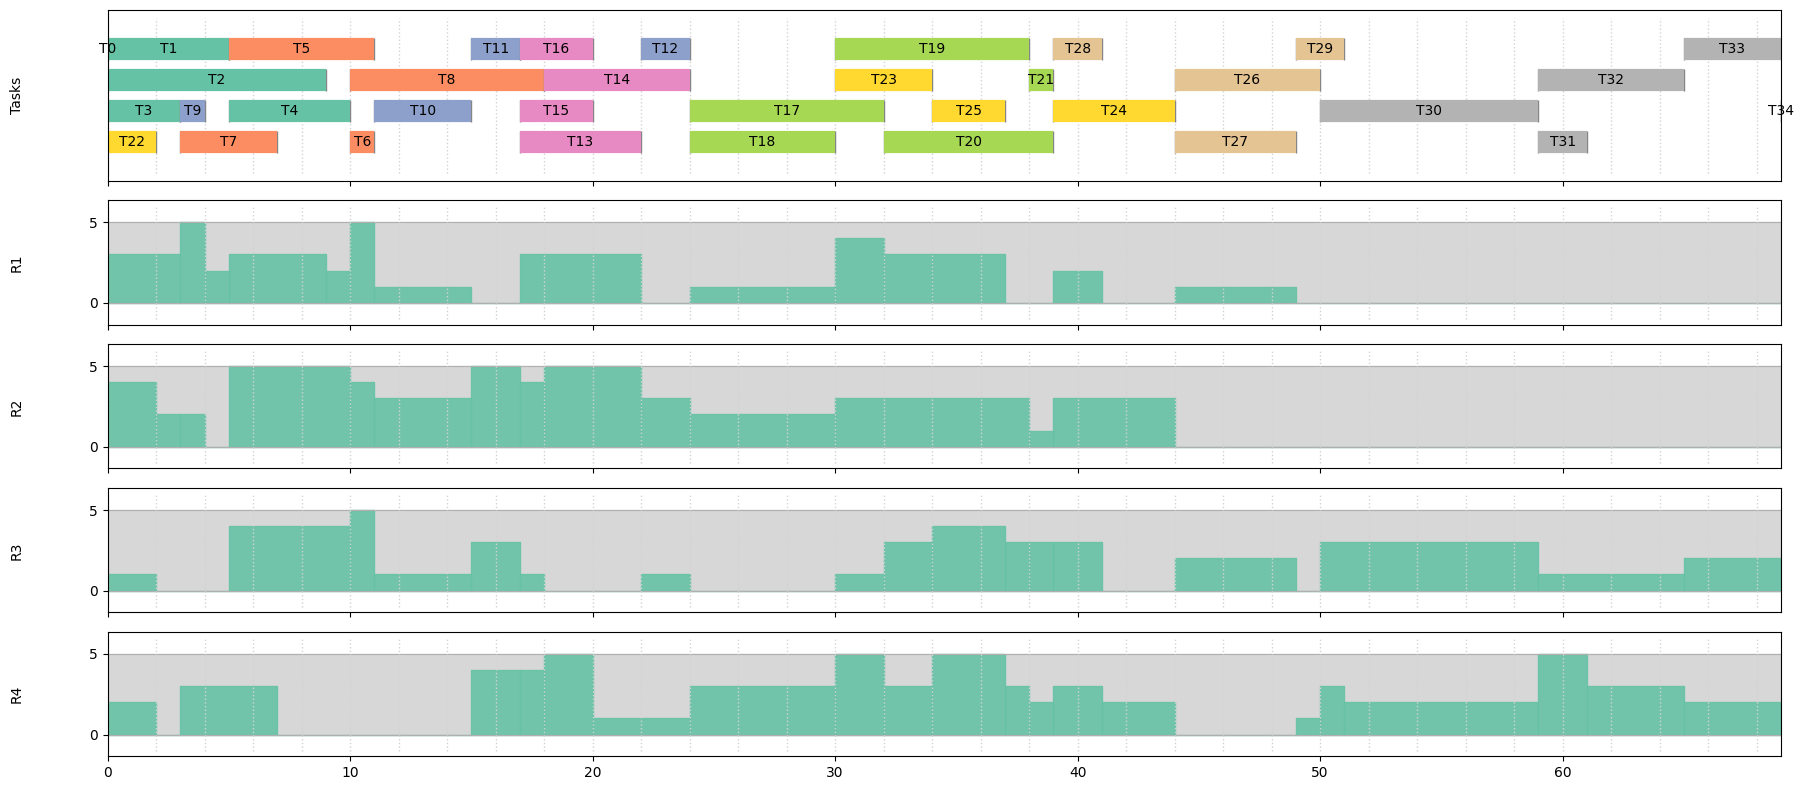

In [7]:
if res and res.is_solution() and visu.is_visu_enabled():
    plt.rcParams["figure.figsize"] = (18, 8)
    loads = [CpoStepFunction() for _ in range(M)] # Build per-resource load step functions from the solved intervals
    for i in range(N):
        itv = res.get_var_solution(x[i])
        if itv.is_present():
            s, e = itv.get_start(), itv.get_end()
            for k in range(M):
                if Q[i][k] > 0:
                    loads[k].add_value(s, e, Q[i][k])

    visu.timeline('Solution for RCPSP ' + filename)
    visu.panel('Tasks')
    for i in range(N):
        visu.interval(res.get_var_solution(x[i]), i, x[i].get_name())
    for k in range(M):
        visu.panel(f'R{k+1}')
        visu.function(segments=[(INTERVAL_MIN, INTERVAL_MAX, C[k])], style='area', color='lightgrey')
        visu.function(segments=loads[k], style='area', color=k)

    visu.show()

### Additional Resources

- **IBM DOcplex CP – RCPSP**
  - https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/visu/rcpsp.py

- **Multimode RCPSP**
    - https://github.com/radovluk/CP_Cookbook/blob/main/notebooks/multimode_rcpsp.ipynb